In [0]:
# input
df = spark.read.option("header","true").option("inferSchema","true").csv("dbfs:/FileStore/tables/smoke_2.csv")

#removing non-useful columns
df2 = df.drop("_c0", "UTC", "CNT").drop_duplicates()
df2.show()

+--------------+-----------+---------+---------+------+-----------+-------------+-----+-----+-----+-----+-----+----------+
|Temperature[C]|Humidity[%]|TVOC[ppb]|eCO2[ppm]|Raw H2|Raw Ethanol|Pressure[hPa]|PM1-0|PM2-5|NC0-5|NC1-0|NC2-5|Fire Alarm|
+--------------+-----------+---------+---------+------+-----------+-------------+-----+-----+-----+-----+-----+----------+
|          20.0|      57.36|        0|      400| 12306|      18520|      939.735|  0.0|  0.0|  0.0|  0.0|  0.0|         0|
|        20.161|      51.84|        0|      400| 12467|      19264|      939.754| 0.84| 3.51|  0.0|4.053| 2.58|         0|
|        20.132|      52.46|        0|      400| 12453|      19195|      939.756|  0.9| 3.78|  0.0|4.369| 2.78|         0|
|        20.175|      51.62|        0|      400| 12467|      19299|      939.755| 0.81| 3.38|  0.0|3.909|2.488|         0|
|        20.059|      54.69|        0|      400| 12403|      18921|      939.744|  0.0|  0.0|  0.0|  0.0|  0.0|         0|
|        20.262|

In [0]:
from pyspark.ml.feature import VarianceThresholdSelector, VectorAssembler
 
assembler1 = VectorAssembler(inputCols=df2.columns, outputCol="features")
assembled_input = assembler1.transform(df2)

In [0]:
# Using Pandas to implement RNN
import pandas as pd
pd_data=df2.toPandas()

In [0]:
# splitting the data into Train and Test dataset

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
Xtrain, Xtest=df2.randomSplit([0.7,0.3],seed=2018)
xtrain=Xtrain.toPandas()
ytrain=xtrain.iloc[:,-1]
xtrain=xtrain.iloc[:,:-1]
xtest=Xtest.toPandas()
ytest=xtest.iloc[:,-1]
xtest=xtest.iloc[:,:-1]

In [0]:
# data preprocessing

scaler = StandardScaler()
scaler.fit(xtrain)
xtrain = scaler.transform(xtrain)
xtest = scaler.transform(xtest)

In [0]:
ytest_arr=ytest.values
ytest_arr

Out[50]: array([0, 0, 1, ..., 0, 0, 0], dtype=int32)

In [0]:
xtest_arr=[(x,y)for x,y in zip(xtest,ytest_arr)]
xtest=xtest_arr

In [0]:
#Define layers and no of nodes per layer 
import numpy as np
#[inputs]+hidden_layers+[outputs] # [12,8,6,9,1]
#Initialize weights, activations, derivatives
weights=[]
activations=[]
derivatives=[]
def initialization(layers=[12,4,6,2,1]):
    global weights
    global activations
    global derivatives
    weights=[]
    activations=[]
    derivatives=[]
    for i in range(len(layers) - 1):
    #weights
        w = np.random.uniform(low=0.1, high=0.5, size=(layers[i], layers[i + 1]))
        weights.append(w)
    #derivatives
        d = np.zeros((layers[i], layers[i + 1]))
        derivatives.append(d)
    for i in range(len(layers)):
        a = np.zeros(layers[i])
        activations.append(a)

In [0]:
#Forward Propogation
def forward_propagate(inputData):

    global activations
    global weights

    act = inputData

    activations[0] = act

        # Network layer iteration
    for index, weight in enumerate(weights):
            # Matrix multiplication between previous activation and weight matrix
        act = sigmoid(np.dot(act, weight))
    
        activations[index + 1] = act
    return act

In [0]:
# Define Sigmoid function

def sigmoid(x):
    y = 1.0 / (1 + np.exp(-x))
    return y

In [0]:
# Define Sigmoid Derivative function

def sigmoid_derivative(x):
    return x * (1.0 - x)

In [0]:
# Define Backward propogation
def back_propagate(error):

    global derivatives
    global activations
    global weights

    for i in reversed(range(len(derivatives))):

            # Activation - previous layer
        act = activations[i+1]

            # Sigmoid derivative function
        delta_value = error * sigmoid_derivative(act)

            # reshape delta
        delta_reshape = delta_value.reshape(delta_value.shape[0], -1).T


            # Activations - current layer
        current_layer_activations = activations[i]

            # Reshape activations
        current_layer_activations = current_layer_activations.reshape(current_layer_activations.shape[0],-1)

            
            # Matrix multiplication
        derivatives[i] = np.dot(current_layer_activations, delta_reshape)

            # backpropogate the next error
        error = np.dot(delta_value, weights[i].T)

In [0]:
# Define Gradient Descent
def gradient_descent(learning_rate=1):
    global derivatives
    global weights
    for i in range(len(weights)):
        weight = weights[i]
        derivative = derivatives[i]
        weight += derivative * learning_rate
        weights[i] = weight

In [0]:
#Make Predictions

def predict(X):

        return np.round(forward_propagate(X))

In [0]:
# Define MSE
 
def mse(target_value, output):
    return np.average((target_value - output) ** 2)

In [0]:
#inputs= xtrain, targets = ytrain
def train(X, Y, layers = [12,4,6,2,1], epochs = 5, learning_rate = 1):
        mse_errors = []
        initialization(layers)
        for i in range(epochs):
            sum_errors = 0
            for j, input in enumerate(X):
                target_value = Y[j]

                # getting output using forward propagation
                output = forward_propagate(input)
               
                error = target_value - output
                back_propagate(error)
                
                # now perform gradient descent on the derivatives
                # (this will update the weights)
                gradient_descent(learning_rate)
                # keep track of the MSE for reporting later
                sum_errors += mse(target_value, output)

            # Epoch complete, report the training error
            error = sum_errors / len(X)
            print("Error {} at epoch {} ".format(error, i+1))
            mse_errors.append(error)

        print("=====*====Training complete!=====*====")
        return mse_errors

In [0]:
# Performing Grid search 

# this step will take around 8-10 minutes
hl=[ [12,4,1], [12,4,6,1], [12,4,6,2,1]]
lr=[0.1,0.05, 0.03]
ep=[5,10]

rdd = sc.parallelize([(i,j,k) for i in hl for j in ep for k in lr])
# Apply the function on each combination of i, j, and k using map
result_rdd = rdd.map(lambda x: ((x[0],x[1],x[2]),train(xtrain, ytrain, x[0], x[1], x[2]))).cache()
result_rdd.collect()

Out[61]: [(([12, 4, 1], 5, 0.1),
  [0.04793837029727784,
   0.024534783257133357,
   0.017965912472426977,
   0.01631308798910771,
   0.016112245355967048]),
 (([12, 4, 1], 5, 0.05),
  [0.06965186523530244,
   0.03359713646685282,
   0.0293519235571685,
   0.028108597819002015,
   0.027624743993184698]),
 (([12, 4, 1], 5, 0.03),
  [0.08994797783460841,
   0.04281986041147115,
   0.03725225805605054,
   0.035083198433719265,
   0.03297255296082744]),
 (([12, 4, 1], 10, 0.1),
  [0.04945072501976578,
   0.0303982695892676,
   0.020511348681522608,
   0.017310477120228745,
   0.016602849375291787,
   0.016504598730967157,
   0.01672991919900118,
   0.017022097752726173,
   0.01707247891817767,
   0.017319207275954183]),
 (([12, 4, 1], 10, 0.05),
  [0.0687761738246145,
   0.03546657454911468,
   0.02921774896546254,
   0.026896671673319376,
   0.026370673473976956,
   0.026014871577871534,
   0.025762417992819496,
   0.025556245422077177,
   0.025429705987752047,
   0.025287932997450763]),


In [0]:
# main
epochs = 10
layers = [12, 4, 6, 1]
mse_errors = train(xtrain, ytrain, layers, epochs, learning_rate=0.05)

epochs_arr = np.arange(1, epochs + 1) 

Error 0.16665093764136493 at epoch 1 
Error 0.10643257695085734 at epoch 2 
Error 0.04080923325649058 at epoch 3 
Error 0.023783274360229867 at epoch 4 
Error 0.022548329782999404 at epoch 5 
Error 0.021177093481575038 at epoch 6 
Error 0.01569438796602731 at epoch 7 
Error 0.014501714937197666 at epoch 8 
Error 0.014607820860171553 at epoch 9 
Error 0.01430075923978159 at epoch 10 
=====*====Training complete!=====*====


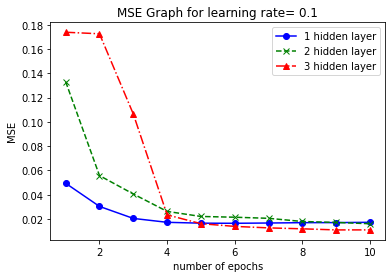

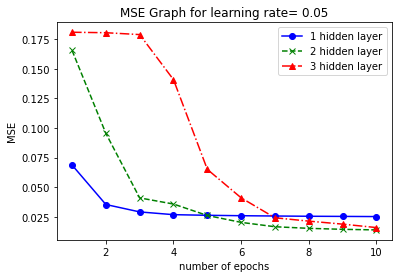

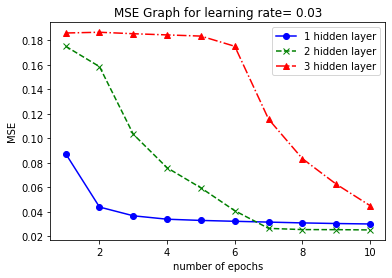

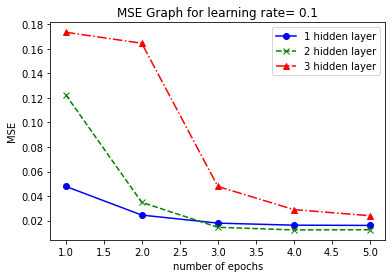

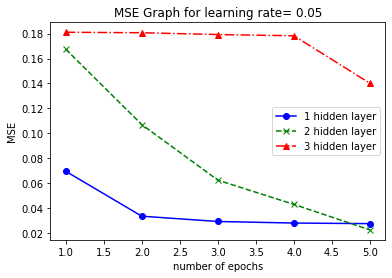

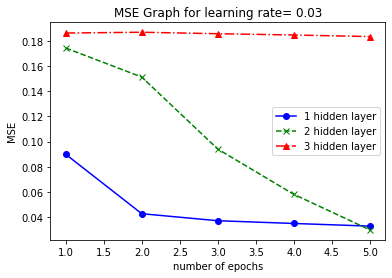

In [0]:
import matplotlib.pyplot as plt

# Create the line graph
combine_learning_rate = result_rdd.map(lambda x :((x[0][1], x[0][2]), (x[0][0], x[1]))).groupByKey().map(lambda x: (x[0], list(x[1])))
grid_search_list = combine_learning_rate.collect()
grid_search_list

for grids in grid_search_list:
    x_arr = np.arange(1, grids[0][0]+1)
    y_arr = grids[1]
    plt.plot(x_arr, grids[1][0][1], label='1 hidden layer', color='blue', marker='o', linestyle='-')
    plt.plot(x_arr, grids[1][1][1], label='2 hidden layer', color='green', marker='x', linestyle='--')
    plt.plot(x_arr, grids[1][2][1], label='3 hidden layer', color='red', marker='^', linestyle='-.')


    # Customize the plot (optional)
    plt.title("MSE Graph for learning rate= {}".format(grids[0][1]))
    plt.xlabel("number of epochs")
    plt.ylabel("MSE")

    # Display the graph
    plt.legend()
    plt.show()

In [0]:
xtest_rdd=sc.parallelize(xtest)


In [0]:
output_rdd=xtest_rdd.map(lambda x:((int(predict(x[0])[0]),x[1]),1))


In [0]:
def serial_testing(xtest):
    predictedValue = []
    for index, xtest_ex in enumerate(xtest):
        predictedValue.append(int(predict(xtest_ex[0])))
    return predictedValue
serial_testing(xtest)

xtest

Out[66]: [(array([-2.63154591e+00, -4.21037280e+00,  7.40823924e+00, -1.51948928e-03,
         -9.72558665e-01, -2.30395780e+00, -1.42635907e+00, -8.13630599e-02,
         -7.93061917e-02, -7.48293452e-02, -7.88994994e-02, -7.21837823e-02]),
  0),
 (array([-2.63147655, -4.21261883,  7.40823924,  0.09822717, -1.35040112,
         -2.55336982, -1.42263092, -0.05278236, -0.06445768, -0.03352529,
         -0.06507062, -0.06993117]),
  0),
 (array([-2.63147655,  0.35018332, -0.071689  , -0.13521135,  0.09493797,
         -0.61058146,  0.07161088, -0.10759171, -0.09296116, -0.11271116,
         -0.09161427, -0.07428924]),
  1),
 (array([-2.63147655,  0.39285781, -0.07092326, -0.13730029,  0.0912696 ,
         -0.6138632 ,  0.06415459, -0.10757013, -0.09295104, -0.11268791,
         -0.09160705, -0.07428832]),
  1),
 (array([-2.63126847,  0.28954061, -0.08291974, -0.14200039,  0.14262683,
         -0.55971454,  0.07683029, -0.10746224, -0.09289541, -0.11252052,
         -0.09155649, -0.074286

In [0]:
performance_metrics = output_rdd.reduceByKey(lambda x,y:x+y)

In [0]:
TP = performance_metrics.lookup((1, 1))[0]
TN = performance_metrics.lookup((0, 0))[0]
FP = performance_metrics.lookup((1, 0))[0]
FN = performance_metrics.lookup((0, 1))[0]

In [0]:
Accuracy = (TP + TN) / (TP + TN + FP + FN)
Precision = TP / (TP + FP)
Recall = TP / (TP + FN)
print("Accuracy of the test data = " + str(Accuracy))
print("Precision of the test data = " + str(Precision))
print("Recall of the test data = " + str(Recall))

Accuracy of the test data = 0.911942615491676
Precision of the test data = 0.981987936875155
Recall of the test data = 0.8928034855769231


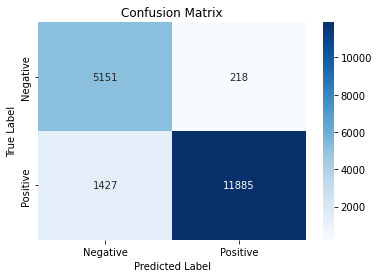

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_confusion_matrix(TP, TN, FP, FN):
    # Create the confusion matrix as a 2x2 NumPy array
    confusion_matrix = np.array([[TN, FP], [FN, TP]])
    
    # Set up the plot
    plt.figure(figsize=(6, 4))
    sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues", 
                xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

plot_confusion_matrix(TP, TN, FP, FN)
